# Alzheimer & MCI DeepLearning(CNN) Classifier
- ADNI MRI 이미지로 알츠하이머와 경도인지장애를 분류하는 딥러닝 프로젝트
- 데이터 출처
  - 메타데이터 : https://ida.loni.usc.edu/
  - MRI이미지 : https://www.kaggle.com/datasets/katalniraj/adni-extracted-axial
- 저작권에 의해 데이터는 깃허브에 업로드 하지 않았음

## Part3-2. Plotting & Prediction
- 본 작업은 로컬환경(VScode)에서 진행되었음.
- 로컬 가상 환경(Conda)
  - OS : Windows11
  - Python version : 3.9
  - Packages : requirments.txt로 설치하여 진행하였음
  - Tensorflow version : 2.7

### 1. Import (Library, Data)

- Library Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model

- Directory 지정 & 폴더 확인

In [2]:
base_dir = "./imagedata/"

data_dir = base_dir + "Axial"

os.listdir(data_dir)

['AD', 'CN', 'MCI']

- Global 변수 지정
  - 클래스 순서, 이미지크기(256), 배치사이즈(32), 시드(42)

In [3]:
CLASSES = ['CN', 'MCI', 'AD']
IMG_SIZE = 256
BATCH_SIZE = 32
SEED = 42

- Data 불러오기

In [4]:
dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    seed=SEED
)
print(dataset.class_names)

Found 5154 files belonging to 3 classes.
['CN', 'MCI', 'AD']


- Image Data 수 확인, plot

In [5]:
number_of_images = {}
for class_name in CLASSES:
    number_of_images[class_name] = len(os.listdir(data_dir+"/"+class_name))
image_count_df = pd.DataFrame(number_of_images.values(),
                              index=number_of_images.keys(),
                              columns=["Number of Images"])
display(image_count_df)
print("\nSum of Images: {}".format(image_count_df.sum()[0]))

,Number of Images
CN,1440
MCI,2590
AD,1124



Sum of Images: 5154


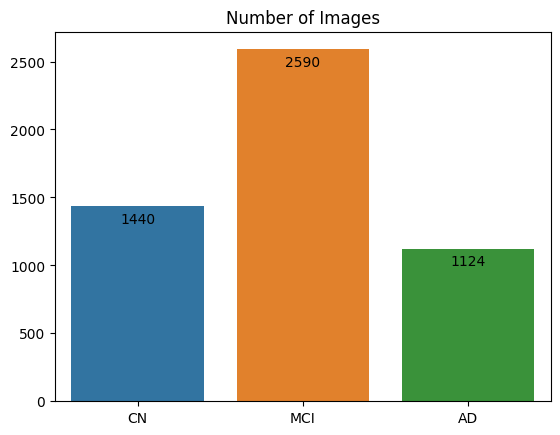

In [6]:
ax = sns.barplot(data=image_count_df.T)

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()-200),
                ha='center', va='center', fontsize=10, color='black',xytext=(0,10),
                textcoords='offset points')

plt.title('Number of Images')
plt.show()

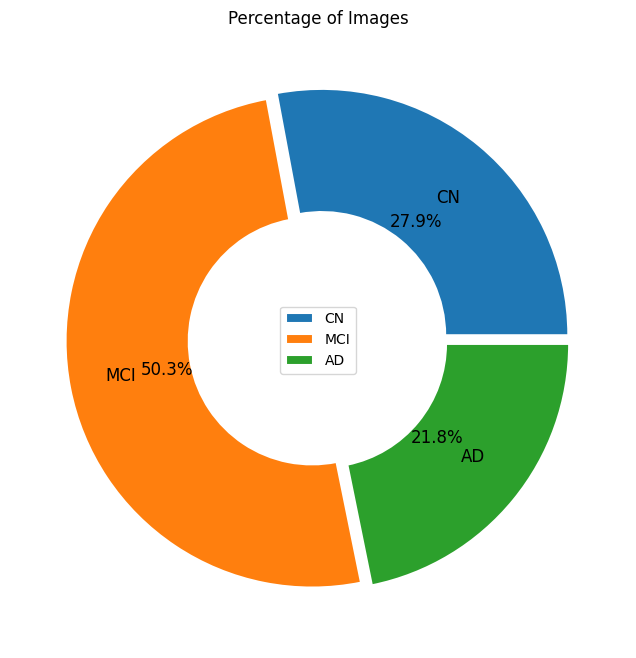

In [7]:
explode = np.repeat(0.025,3)
wedgeprops = {'width': 0.5, 'edgecolor': 'w', 'linewidth': 1.5}
textprops={'size':12}
icd = image_count_df.reset_index(drop=False)
icd.columns = ['Group', 'Counts']
plt.figure(figsize=(8,8))
plt.pie(icd.Counts,labels=icd.Group,
        labeldistance=0.725,startangle=0,autopct='%.1f%%',
        explode=explode,wedgeprops=wedgeprops,textprops=textprops)
plt.legend(loc='center')
plt.title('Percentage of Images')
plt.show()

- 데이터 확인
  - Batch 하나 뽑아서 형태 및 Label 확인하였음

In [8]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    print(label_batch.shape)
    break

(32, 256, 256, 3)
[2 2 1 1 1 1 1 2 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 2 1 0 0 0]
(32,)


- 이미지 데이터 픽셀값 범위 확인
  - 정규화는 모델에서 정규화 layer가 포함되어 있으므로 여기선 정규화를 따로 진행하지 않음

In [9]:
np.min(img_batch), np.max(img_batch)

(0.0, 255.0)

In [10]:
print(np.unique(label_batch))
print(dataset.class_names)

[0 1 2]
['CN', 'MCI', 'AD']


In [11]:
class_dict = dict(zip(np.unique(label_batch),dataset.class_names))
class_dict

{0: 'CN', 1: 'MCI', 2: 'AD'}

- 데이터 확인 Matplotlib
  - 이미지 데이터를 제대로 불러왔는지 확인
  - 육안으로는 구분하기 힘들듯 -> 딥러닝의 필요성 !

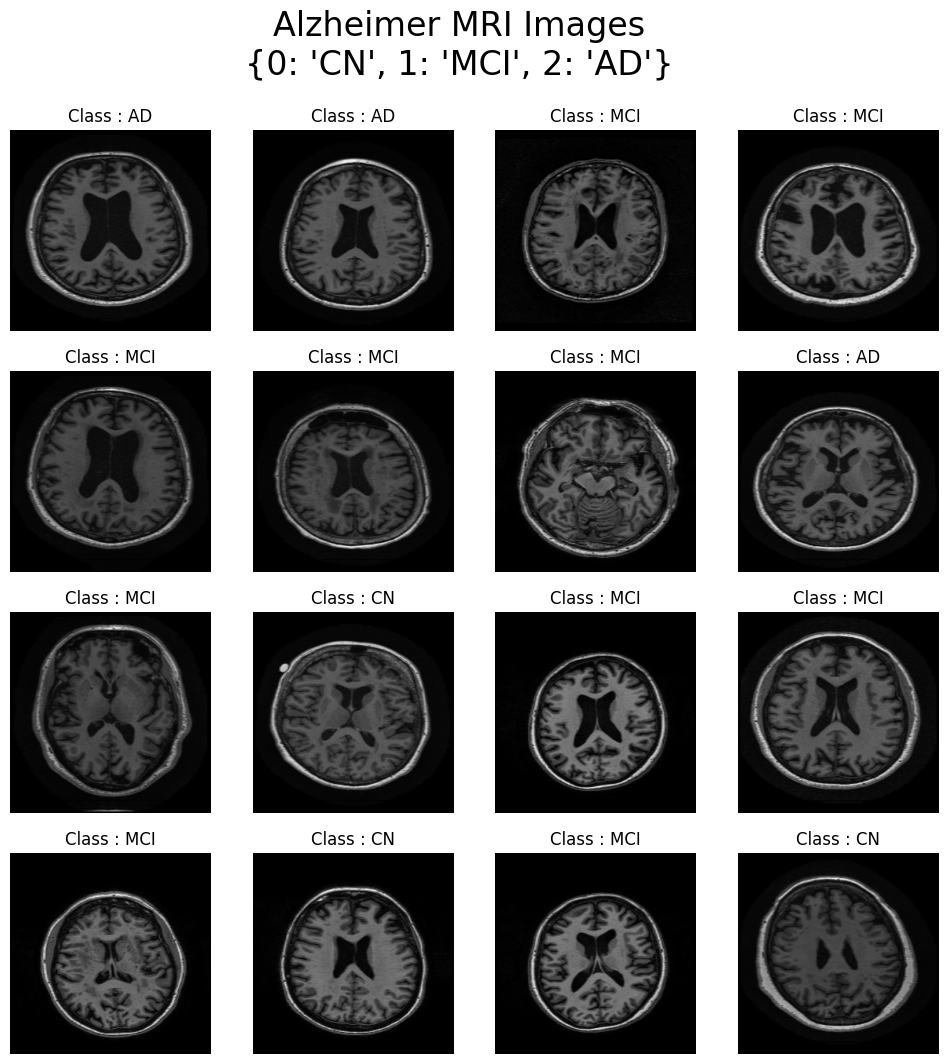

In [12]:
plt.figure(figsize=(12,12))
plt.suptitle(f"Alzheimer MRI Images\n{class_dict}", fontsize=24)
for i in range(16):
  ax = plt.subplot(4,4,i+1)
  img_arr = img_batch[i].numpy()
  plt.imshow(img_arr.astype("uint8"))
  plt.axis("off")
  plt.title("Class : {}".format(CLASSES[label_batch[i].numpy()]))

### 2. Data Split & Prefetch

- Data Split
  - Train : Validation : Test = 0.8 : 0.1 : 0.1
  - Batch 단위로 묶인 데이터라 Batch단위로 Split

In [13]:
def dataset_split(ds, tr=0.8, val=0.1, test=0.1, shuffle=True, buf_size=10000, SEED=42):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(buf_size,seed=SEED)
  train_size = int(ds_size*tr)
  val_size = int(ds_size*test)
  
  train = ds.take(train_size)
  test0 = ds.skip(train_size)
  val = test0.take(val_size)
  test = test0.skip(val_size)

  return train,val,test

train_ds, val_ds, test_ds = dataset_split(dataset)
print("Split전 Batched data 개수")
print(f"Dataset : {len(dataset)}")
print("\nSplit후 Batched data 개수")
print(f"Train : {len(train_ds)}")
print(f"Validation : {len(val_ds)}")
print(f"Test : {len(test_ds)}")

Split전 Batched data 개수
Dataset : 162

Split후 Batched data 개수
Train : 129
Validation : 16
Test : 17


### 3. Model 불러오기 & Evaluation
- model1 : 튜닝을 거치지 않은 Vanilla CNN model
- final_model : 튜닝을 거친 후 학습된 CNN model

In [14]:
model1_path = base_dir + "model1.hdf5"
model1 = load_model(filepath=model1_path)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [15]:
final_model_path = base_dir + "best_model.hdf5"
final_model = load_model(filepath=final_model_path)
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 128, 128, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 128, 128, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 64, 64, 16)         0         
 2D)                                                  

- evaluation (test dataset)

In [16]:
model1.evaluate(test_ds, verbose=1)

17/17 [==============================] - 7s 114ms/step - loss: 0.2975 - acc: 0.8934


[0.2974990904331207, 0.8933823704719543]

In [17]:
final_model.evaluate(test_ds, verbose=1)

17/17 [==============================] - 5s 62ms/step - loss: 0.0443 - acc: 0.9853


[0.04426185041666031, 0.9852941036224365]

### 4. Prediction & Image Showing
- 무작위로 섞인 데이터를 뽑아서 예측 및 시각화 진행
- 시각화는 12개의 이미지로 진행

In [18]:
for image_test, label_test in test_ds.take(1):
    print(image_test.shape)
    print(label_test.numpy())
    print(label_test.shape)
    break

(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 1 1 1 2 1 2 2 2 1 1 2 0 1 2 0 1 1 1 1 1 1 0 0 0]
(32,)


- 이미지 시각화 함수 정의
  - matplotlib.pyplot 의 imshow 기능 이용

In [19]:
def prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array, verbose=0)
    
    predicted_class = CLASSES[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), ndigits=2)

    return predicted_class, confidence

def pred_plot(model):
    plt.figure(figsize=(12,12))
    plt.suptitle(f"Alzheimer MRI Images {class_dict}", fontsize=24)
        
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_test[i].numpy().astype("uint8"))
        predicted_class, confidence = prediction(model, image_test[i].numpy())
        label_true = CLASSES[label_test[i].numpy()]
        plt.title("Actual : {}\nPredicted : {}\nConfidence : {}".format(label_true, predicted_class, confidence))
        plt.axis("off")


- 튜닝을 거치지 않은 Vanilla CNN 모델
  - 군데군데 예측을 잘못한 이미지가 있었음
  - 판단에대한 신뢰도(confidence)도 상대적으로 낮은 이미지들도 나타남

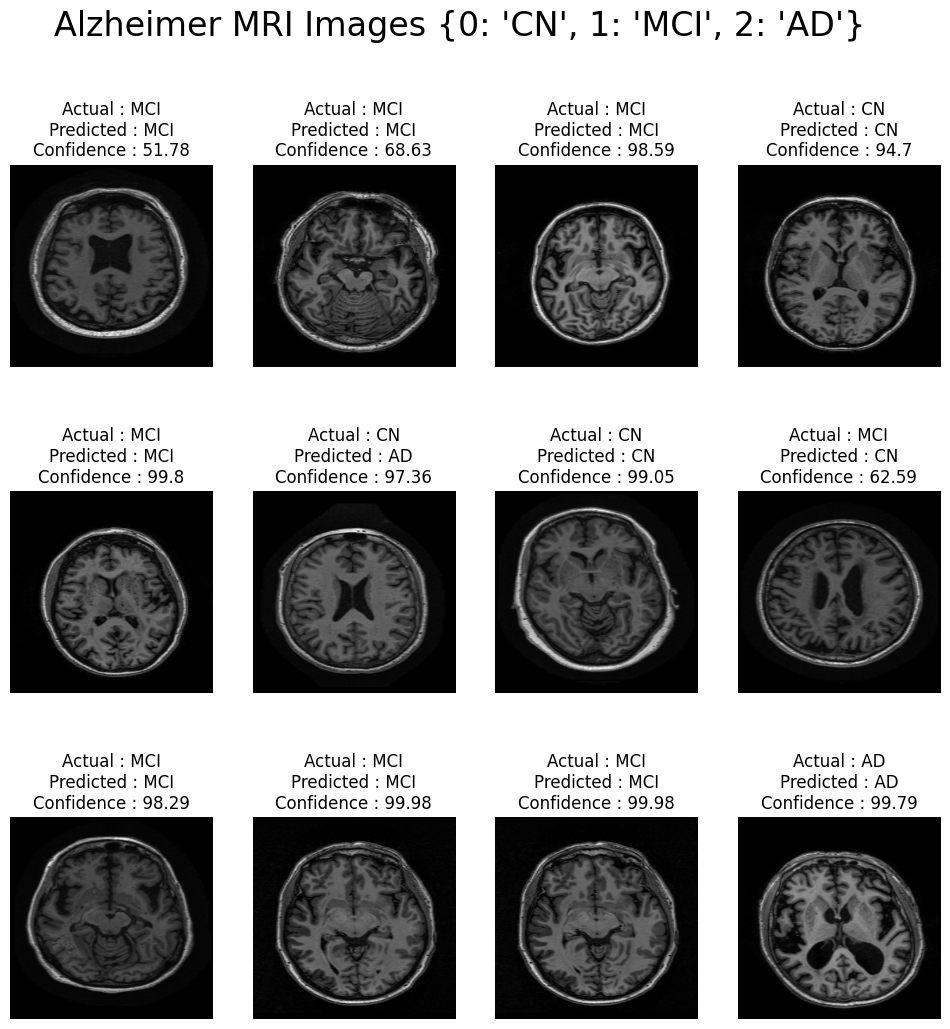

In [20]:
pred_plot(model1)

- 튜닝을 거친 최종 CNN 모델
  - vanilla CNN보다 향상된 예측 성능을 보임
  - 예측에 대한 confidence도 상대적으로 훨씬 높았음

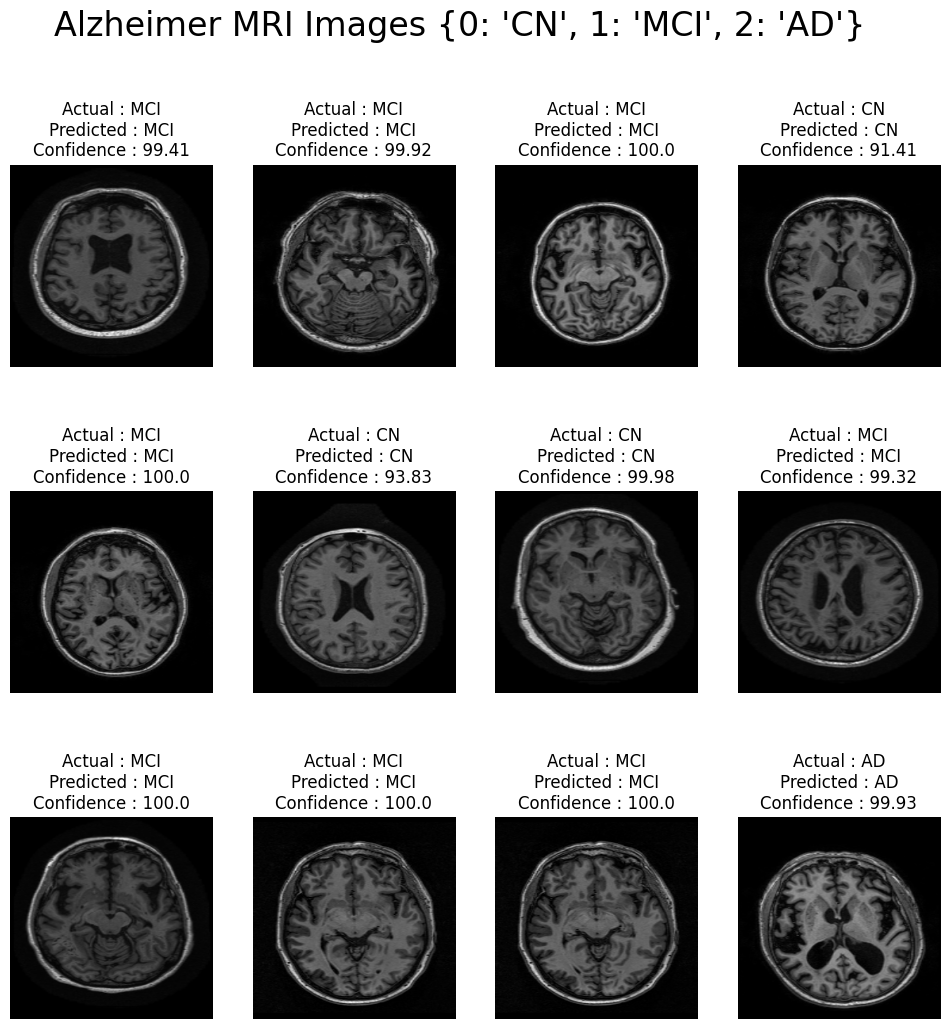

In [21]:
pred_plot(final_model)

### 5. Classification report & Confusion Matrix
- 테스트 데이터셋 전체에 대한 예측 성능을 비교분석
- scikit-learn의 기능을 이용

In [22]:
# Test Data Label, 각 모델별 predicted Label array 생성
real_label = np.array([])
pred_model1 = np.array([])
pred_final_model = np.array([])
for imgs, labels in test_ds:
    real_label = np.concatenate([real_label, labels.numpy()])
    pred_model1 = np.concatenate([pred_model1, np.argmax(model1(imgs), axis=-1)])
    pred_final_model = np.concatenate([pred_final_model, np.argmax(final_model(imgs), axis=-1)])

label_df = pd.DataFrame(zip(real_label, pred_model1, pred_final_model),
                        columns = ['True_Label', 'Pred_Vanilla', 'Pred_Tuned'])
label_df2 = label_df.replace(class_dict)
label_df2.head(10)

,True_Label,Pred_Vanilla,Pred_Tuned
0,CN,CN,CN
1,MCI,MCI,MCI
2,CN,MCI,CN
3,MCI,MCI,MCI
4,AD,AD,AD
5,MCI,MCI,MCI
6,MCI,MCI,MCI
7,MCI,MCI,MCI
8,CN,CN,CN
9,CN,CN,CN


- 테스트 데이터셋 비율 확인

In [23]:
count_label = label_df2['True_Label'].value_counts()
label_dict = {}
for class_name in CLASSES:
    label_dict[class_name] = count_label.loc[class_name]
print(f"Label Counts : {label_dict}")

image_count_test = pd.DataFrame(label_dict.values(),
                                index = label_dict.keys(),
                                columns=["Test_Dataset"])
display(image_count_test)
print("Sum of Images : {}".format(image_count_test.sum()[0]))

Label Counts : {'CN': 172, 'MCI': 268, 'AD': 104}


,Test_Dataset
CN,172
MCI,268
AD,104


Sum of Images : 544


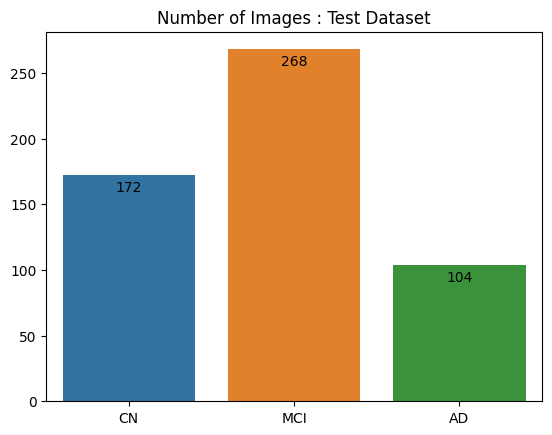

In [24]:
# Test data count barplot
ax2 = sns.barplot(data=image_count_test.T)

for p2 in ax2.patches:
    ax2.annotate("%.0f" % p2.get_height(), (p2.get_x() + p2.get_width()/2., p2.get_height()-20),
                ha='center', va='center', fontsize=10, color='black',xytext=(0,10),
                textcoords='offset points')

plt.title('Number of Images : Test Dataset')
plt.show()

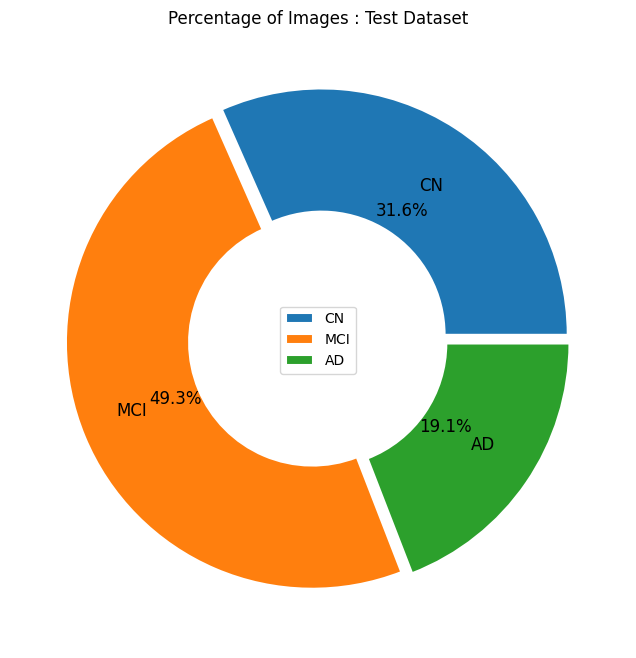

In [25]:
# Test data pie plot
explode = np.repeat(0.025,3)
wedgeprops = {'width': 0.5, 'edgecolor': 'w', 'linewidth': 1.5}
textprops={'size':12}
ict = image_count_test.reset_index(drop=False)
ict.columns = ['Group', 'Counts']
plt.figure(figsize=(8,8))
plt.pie(ict.Counts,labels=ict.Group,
        labeldistance=0.725,startangle=0,autopct='%.1f%%',
        explode=explode,wedgeprops=wedgeprops,textprops=textprops)
plt.legend(loc='center')
plt.title('Percentage of Images : Test Dataset')
plt.show()

- Classcification Report, Confusion Matrix 함수 정의

In [26]:
def report_matrix(y_real, pred_label, subtitle):
    
    print(classification_report(y_real, pred_label, target_names=CLASSES))
    
    cm = confusion_matrix(y_real, pred_label)
    plt.figure(figsize=(8,6), facecolor='w', edgecolor='k')
    ax = sns.heatmap(data=cm, cmap='Greens', annot=True, fmt='d',
                     xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f"Confusion Matrix of Alzheimer-MCI Prediction\nModel : {subtitle}")
    plt.xlabel('Prediction')
    plt.ylabel('True(Real)')
    plt.show(ax)

- 튜닝을 거치치 않은 Vanilla CNN model

              precision    recall  f1-score   support

          CN       0.96      0.88      0.92       172
         MCI       0.89      0.95      0.92       268
          AD       0.88      0.83      0.85       104

    accuracy                           0.91       544
   macro avg       0.91      0.89      0.90       544
weighted avg       0.91      0.91      0.91       544



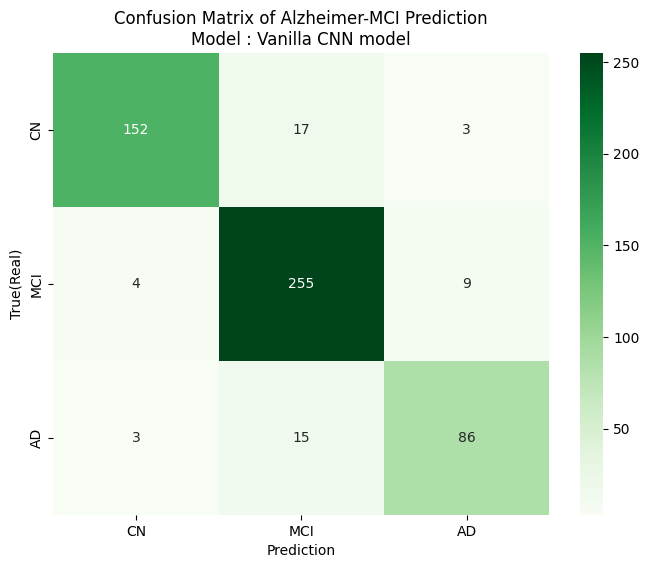

In [27]:
report_matrix(real_label, pred_model1, subtitle='Vanilla CNN model')

- 튜닝을 거친 후의 Final CNN model

              precision    recall  f1-score   support

          CN       0.97      0.98      0.98       172
         MCI       0.99      0.97      0.98       268
          AD       0.97      0.99      0.98       104

    accuracy                           0.98       544
   macro avg       0.98      0.98      0.98       544
weighted avg       0.98      0.98      0.98       544



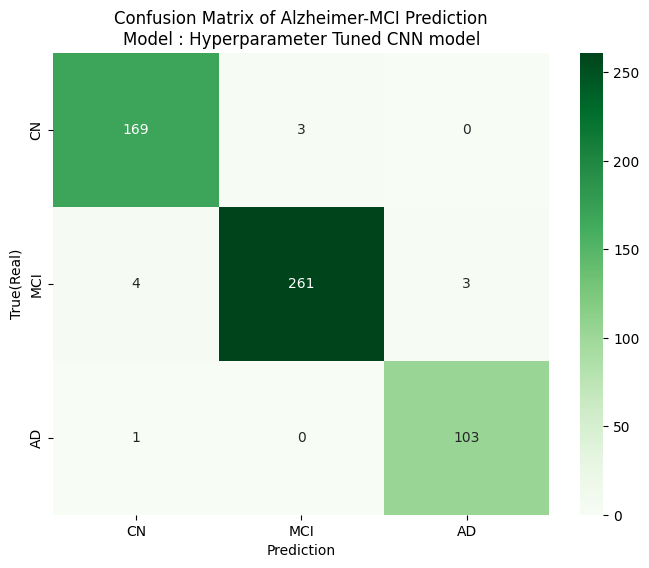

In [28]:
report_matrix(real_label, pred_final_model, subtitle='Hyperparameter Tuned CNN model')